In [127]:
"""
Created on Sun Feb 12 2022

@author: Kevin Taylor
"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from math import *
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from scipy import signal
from scipy.fft import fft, ifft
from statsmodels.tsa.stattools import acovf
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import openpyxl
import warnings
warnings.filterwarnings('ignore')
from time import time
import seaborn as sns
sns.set(style="whitegrid")

In [119]:
weekly_usage = pd.read_csv(
    '../Raw Data/weekly_usage.csv',
    index_col = 0
    ) # read the data from the preprocessed .csv file
weekly_usage.drop(weekly_usage[weekly_usage.value==0].index, inplace=True) # drop zeros from analysis for accounts not yet created
weekly_usage.drop(
    weekly_usage[weekly_usage.t.isin([min(weekly_usage.t), max(weekly_usage.t)])].index, inplace = True
) # drop first and last week, could be partial weeks of data and skew results
weekly_usage.t = weekly_usage.t - 1

In [121]:
weekly_overall = weekly_usage.groupby(['year', 'week'], as_index = False).mean() # aggregate overall all accounts, mean usage in kWh

<Figure size 1000x700 with 0 Axes>

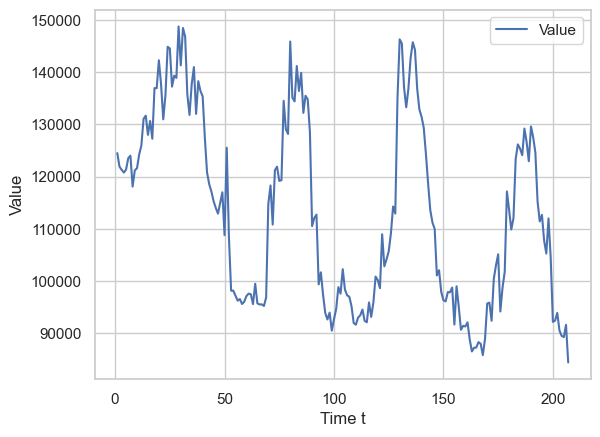

<Figure size 1000x700 with 0 Axes>

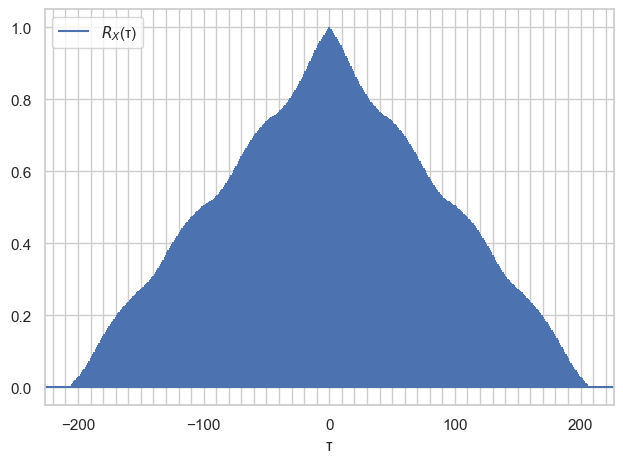

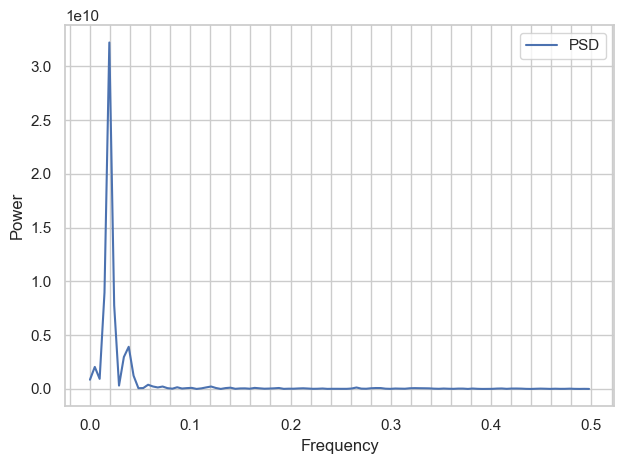

Max Power at period 51.75


In [122]:
# Overall ts plot for all accounts combined
plt.figure(figsize=(10, 7))
fig, ax = plt.subplots()
plt.plot(weekly_overall.t, weekly_overall.value)
plt.ylabel('Value')
plt.xlabel('Time t')
plt.legend(['Value'])
plt.grid(True)
plt.show()

# Autocorrelation for all accounts combined
plt.figure(figsize=(10, 7))
fig, ax = plt.subplots()
ax.acorr(weekly_overall.value.values ,maxlags = None)
minor_locator = AutoMinorLocator(10)
ax.xaxis.set_minor_locator(minor_locator)
plt.grid(which='minor')
plt.legend(['$R_X$(\u03C4)'],loc='upper left')
plt.xlabel('\u03C4')
# plt.ylabel('Power')
ax.grid(True, which='both')
plt.tight_layout()
plt.show()

# Overall PSD for all accounts combined
freqs, psd = signal.welch(weekly_overall.value.values)
fig, ax = plt.subplots()
ax.plot(freqs, psd)
minor_locator = AutoMinorLocator(5)
ax.xaxis.set_minor_locator(minor_locator)
plt.grid(which='minor')
plt.legend(['PSD'])
plt.xlabel('Frequency')
plt.ylabel('Power')
ax.grid(True, which='both')
plt.tight_layout()
plt.show()
print('Max Power at period {}'.format(1/freqs[psd == max(psd)][0]))


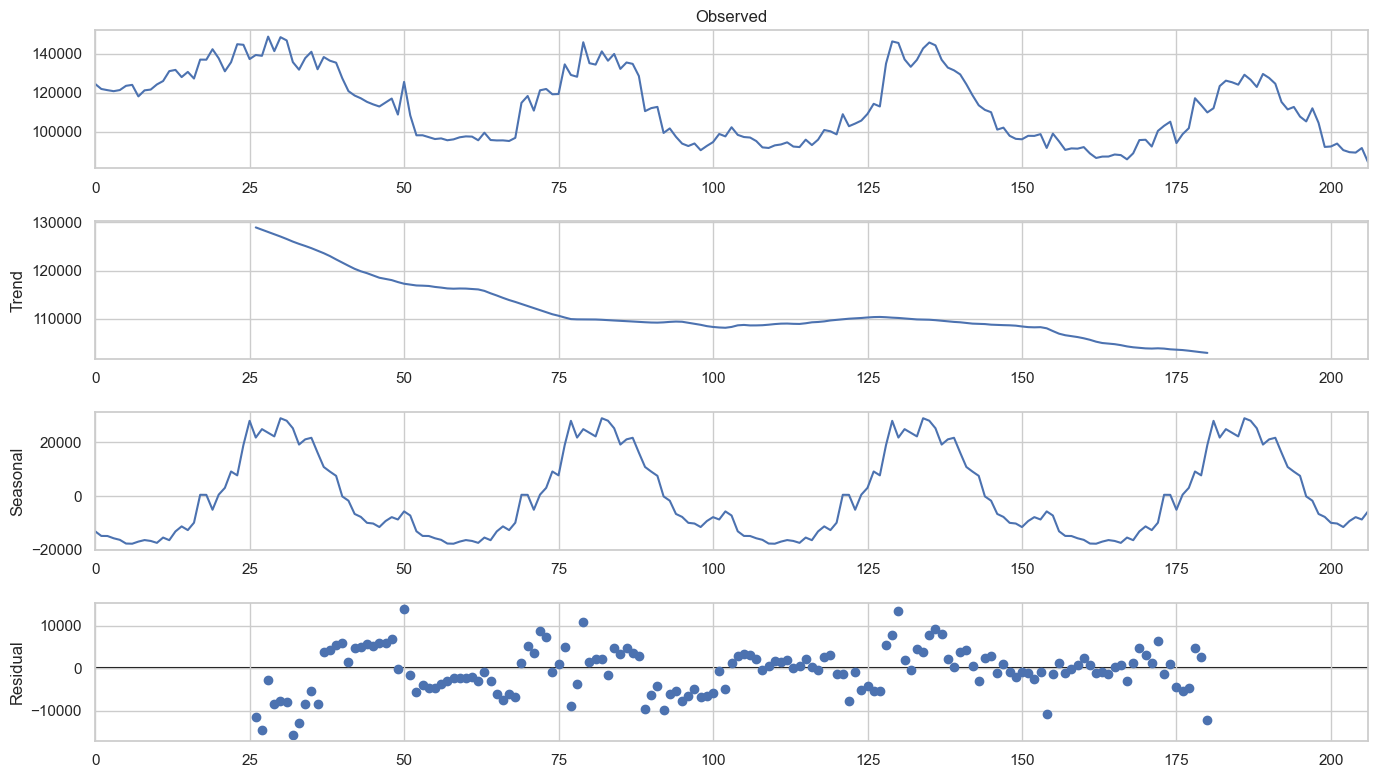

In [125]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=14)
result = seasonal_decompose(weekly_overall.value.values, period = 52, model='additive')
fig = result.plot()
# Appears to have 1st order trend with seasonal component, period of 52

In [161]:
sarimax_model = SARIMAX(
    weekly_overall.value.values,
    order = (1, 1, 1),
    seasonal_order = (1, 1, 1, 52)).fit(max_iter = 50, method = 'powell')

Optimization terminated successfully.
         Current function value: 7.572093
         Iterations: 8
         Function evaluations: 491


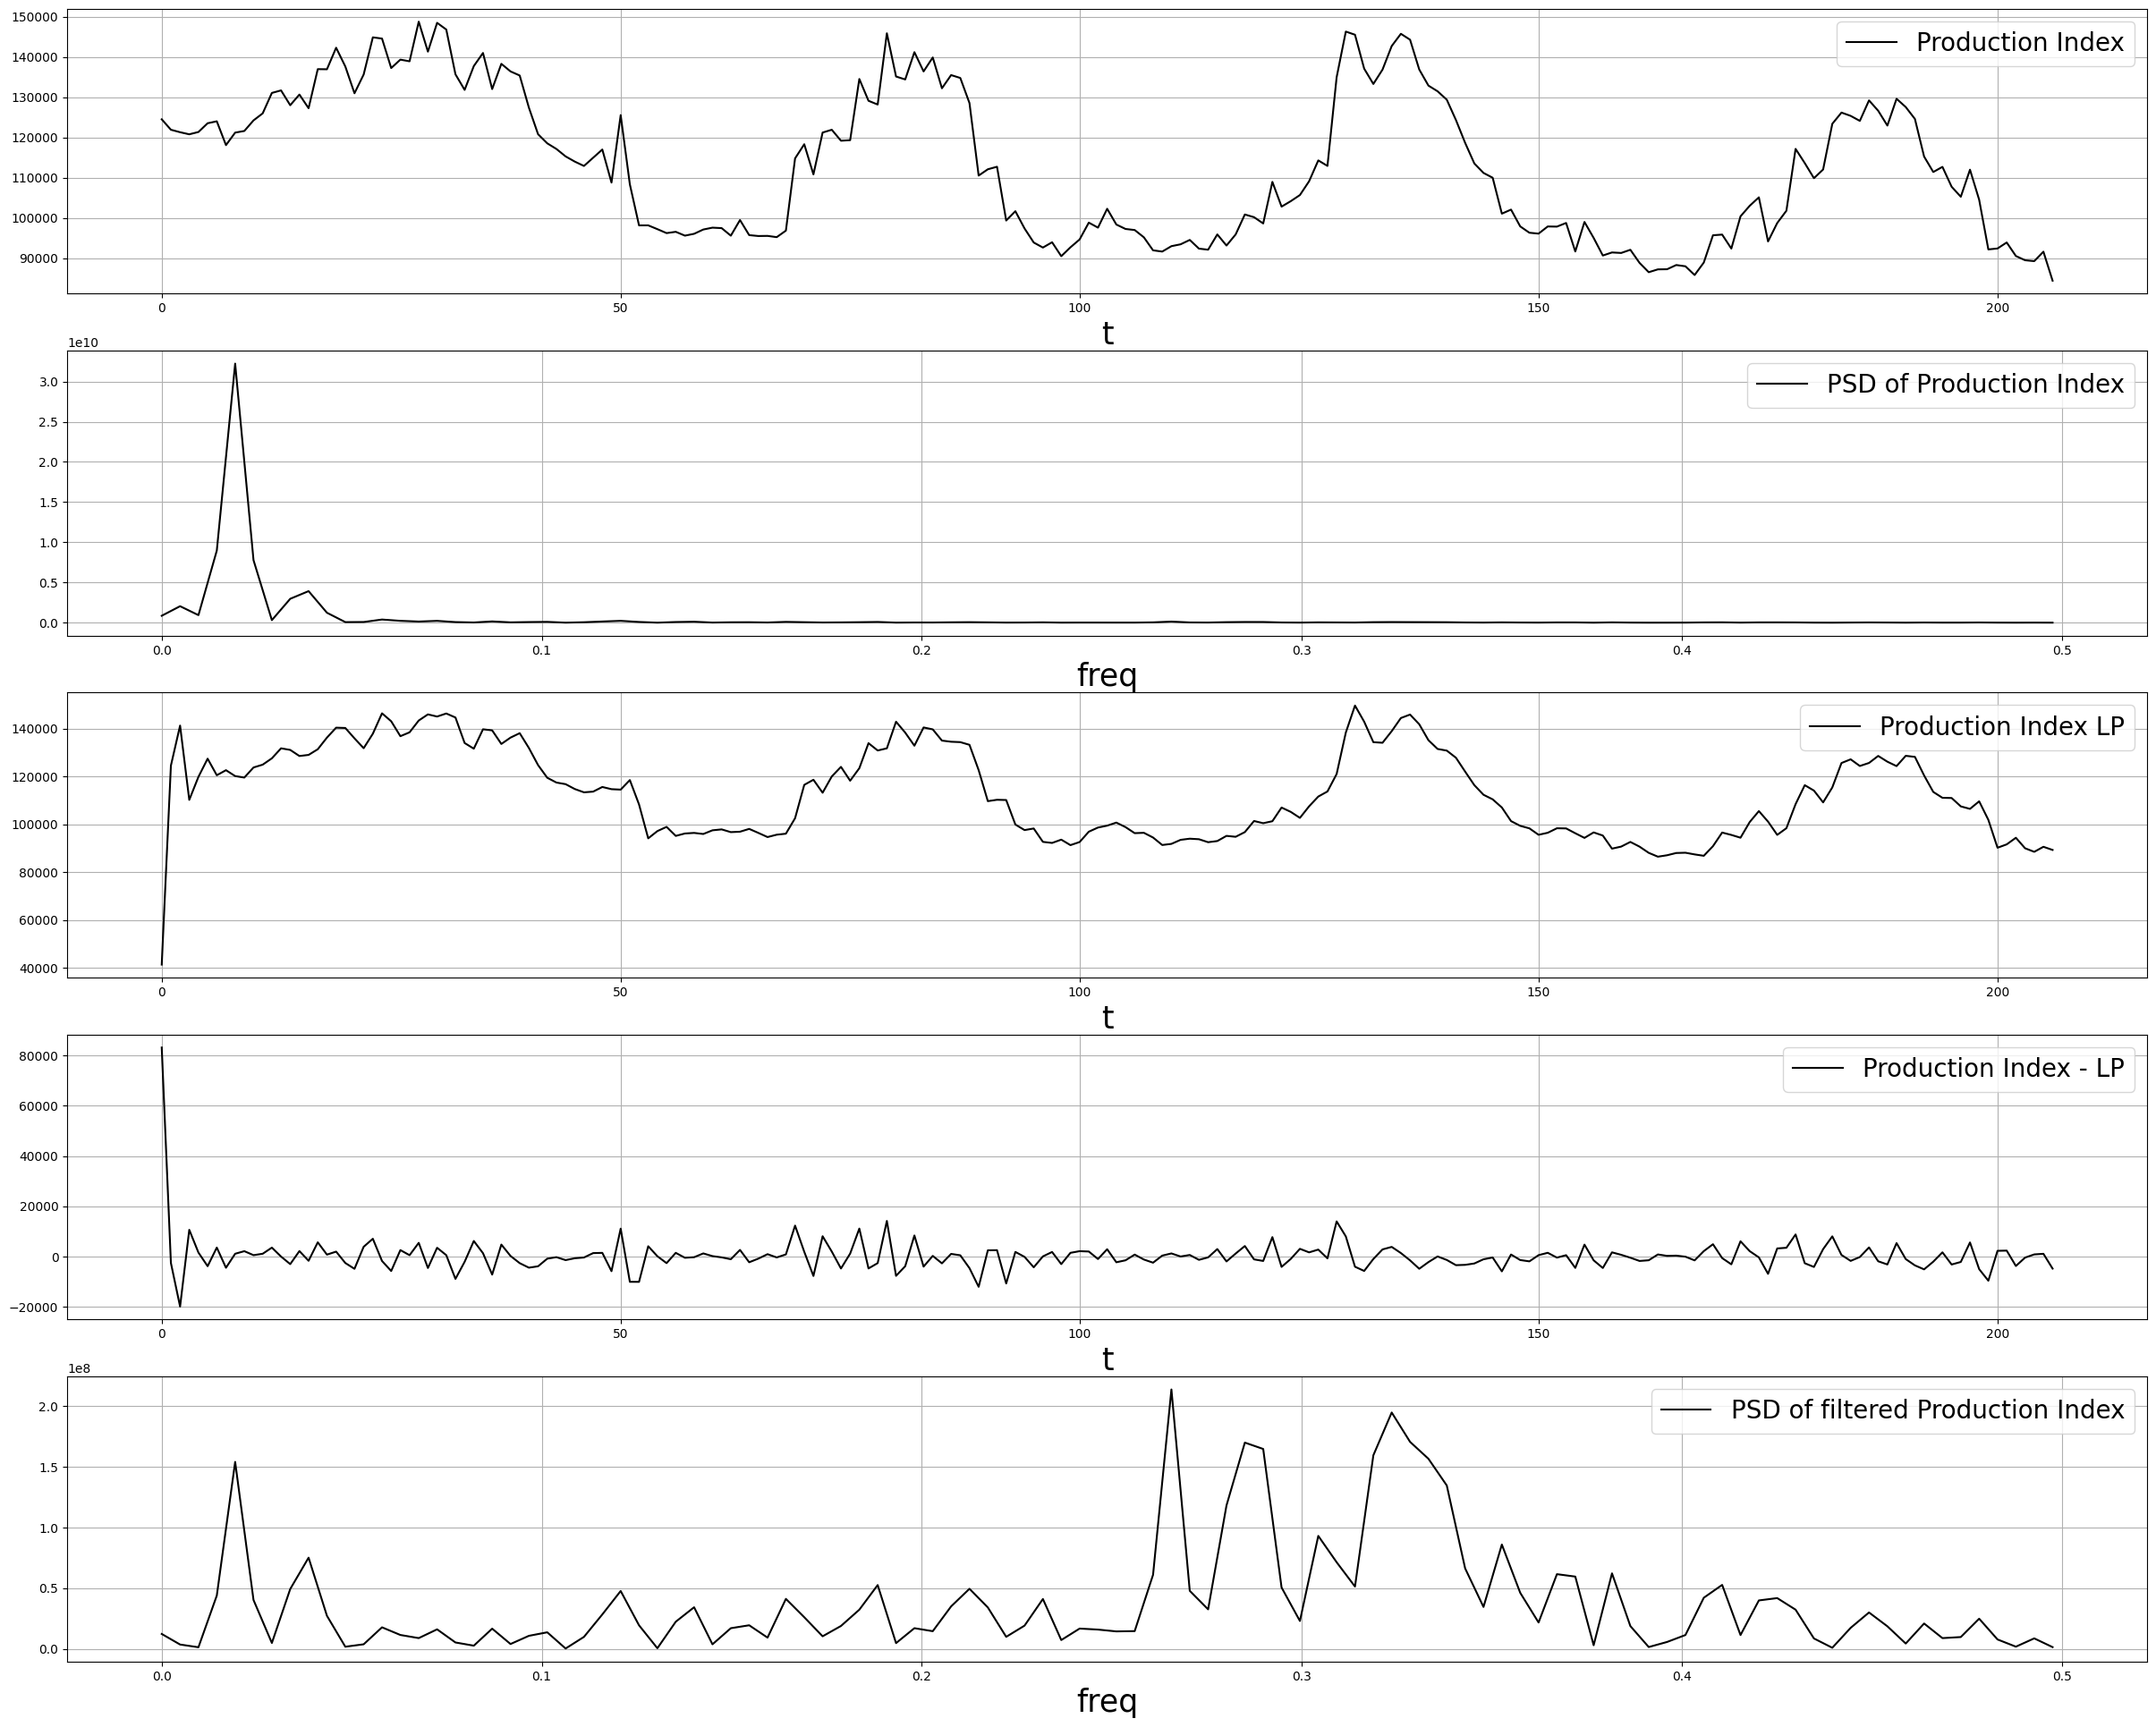

In [117]:
# Low Pass Filter for overall
t = weekly_overall.t
sig = weekly_overall.value.values
RMSE = 1e9
fss=0
order=0

for i in np.arange(3,20):
    for j in np.arange(i,60):
        sos = signal.butter(i, 1, 'lowpass', fs=j, output='sos')
        filtered = signal.sosfilt(sos, sig)
        MSE = np.square(sig-filtered).mean() 
        if(RMSE > math.sqrt(MSE)):
            RMSE = math.sqrt(MSE)
            order = i
            fss = j
            
sos = signal.butter(order, 1, 'lowpass', fs=fss, output='sos')
filtered = signal.sosfilt(sos, sig)
fig = plt.figure(figsize=(30, 24))
ax1 = plt.subplot(511)
plt.plot(t, sig,'k')
plt.xlabel('t',fontsize=25)
plt.legend(['Production Index'],fontsize=20)
freqs, psd = signal.welch(sig)
plt.grid(True)
ax2 = plt.subplot(512)
plt.plot(freqs, psd,'k')
plt.xlabel('freq',fontsize=25)
plt.legend(['PSD of Production Index'],fontsize=20)
plt.grid(True)
ax3 = plt.subplot(513)
plt.plot(t, filtered,'k')
plt.xlabel('t',fontsize=25)
plt.legend(['Production Index LP'],fontsize=20)
plt.grid(True)
ax4 = plt.subplot(514)
plt.plot(t,sig-filtered,'k')
plt.xlabel('t',fontsize=25)
plt.legend(['Production Index - LP'],fontsize=20)
freqs, psd = signal.welch(sig-filtered)
plt.grid(True)
ax5 = plt.subplot(515)
plt.plot(freqs, psd,'k')
plt.xlabel('freq',fontsize=25)
plt.legend(['PSD of filtered Production Index'],fontsize=20)
plt.grid(True)
# plt.savefig('ProductionIndex_Butterworth.png')
plt.show()
MSE = np.square(sig-filtered).mean()
RMSE = math.sqrt(MSE)